# Learning a Correction for Particle-Mesh Simulations


## Introduction


Full resolution dark matter-only simulations, while offering detailed insights, require millions of CPU hours due to their computational intensity. Particle mesh (PM) schemes provide a faster alternative at the expense of precision, primarily on smaller scales. This project seeks to enhance the accuracy of PM simulations by employing machine learning techniques such as symbolic regression to correct the PM equations. The objective is to align the corrected PM simulations more closely with n-body simulations, ideally matching their power spectra and cross-correlations, thus improving cosmological parameter inference and scientific accuracy. Work has already been made on this project, but different models should be explored to model the correction.

Paper: [link](https://arxiv.org/pdf/2311.18017)


- Cosmological simulations are very expensive to compute. A full suite may take millions of CPU hours to compute.
- We have access to full suites such as CAMELS
- The particle-mesh method enables fast simulation speeds at the cost of accuracy, mainly in the small scales.
- The plan is to correct the simulation to preserve the small scale structures.
- The correction happens at the equation level.
- Currently, we have a NN parametrizing a B-spline, but we would like to explore different models, mainly symbolic regression, for a more interpretable or more accurate correction.

## Methodology Overview

The current network is a fully connected neural network whose outputs are the coefficients of a B-spline of order 3. It is effectively an isotropic filter in fourier space to preserve translational and rotational symmetries. The model learns to correct the PM potential during the simulation.

$$
\textcolor{white}{\big
\vec{F} = - \nabla (\Phi + Correction)}
$$

The ODE is the following:


\begin{align}
    \frac{dx}{da} &= \frac{v}{a^3E(a)}\\
    \frac{dv}{da} &= \frac{F_{\theta}(x, a, \Omega_m, \sigma_8)}{a^2E(a)}
\end{align}

where the force is given by the following equation which integrates the neural network.

\begin{equation}
    F_{\theta}(x, a, \Omega_m, \sigma_8) = \frac{3\Omega_m}{2}\nabla \left(\phi_{PM}(x) * \mathcal{F}^{-1}(1-f_{\theta}(a, |k|, \Omega_m, \sigma_8))\right)
\end{equation}

Here, $x$ represents the positions of the particles, and $a$ corresponds to the cosmological scale factor. We use $\mathcal{F}^{-1}$ to denote inverse Fourier transform, and $f_{\theta}(a, |k|, \Omega_m, \sigma_8)$ to represent the neural network. 

Run the following code if using Google Collab:

!git clone https://github.com/rouzib/PMpp.git
%cd PMpp

In [ ]:
!pip install dm-haiku jax_cosmo pylians

In [2]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [3]:
from typing import Tuple
from functools import partial

import numpy as np
from jax._src.basearray import ArrayLike
from matplotlib import pyplot as plt
import matplotlib
import jax.numpy as jnp
import haiku as hk
import jax
import optax
from jax.experimental.ode import odeint
from tqdm import tqdm

from jaxpm.kernels import fftk
from jaxpm.painting import cic_paint, compensate_cic
from jaxpm.pm import make_neural_ode_fn
from jaxpm.utils import power_spectrum, cross_correlation_coefficients
from src.PMpp import load_lh, run_pm, run_pm_model

In [4]:
# Set matplotlib parameters for plots in dark mode.
matplotlib.rcParams["figure.facecolor"] = "1e1f22"
matplotlib.rcParams["axes.facecolor"] = "1e1f22"
matplotlib.rcParams["savefig.facecolor"] = "1e1f22"
matplotlib.rcParams['text.color'] = "white"
matplotlib.rcParams['axes.labelcolor'] = "white"
matplotlib.rcParams['xtick.color'] = "white"
matplotlib.rcParams['ytick.color'] = "white"

## Loading the Data

The simulation's positions, velocities, redshift and cosmologies are in files formatted as `CamelsSims/LH_{simulation number}_{type}_{n_mesh}_{seed}.npy`.

Where:
- `type` can be "pos", "vel", "z" or "cosmo" for each data type.
- `n_mesh` is not used for cosmologies.
- `seed` is only used for positions and velocities.

Use function `load_lh` to load the simulation's data. The data should be normalized before used in the simulations.

To generate these files, see `read_camels_lh_set` in [src.SaveLHSims](src/SaveLHSims.py).

In [5]:
sims = [0]  # Simulation index
n_mesh = 32  # Number of mesh points
box_size = [25.0] * 3  # Simulation box size

# Load Latin Hypercube simulation data
targetP, targetV, z, cosmology = load_lh(sims, box_size, n_mesh, path="CamelsSims", normalize=True, cpu_memory=False,
                                         debug=False)
targetP, targetV = targetP[0], targetV[0]  # Get target positions and velocities
initialP, initialV = targetP[0], targetV[0]  # Initializing position & velocity
cosmology = cosmology[0]  # Get the cosmology
scale_factors = 1 / (1 + jnp.array(z))  # Convert redshift to scale factor

print(f"{targetP.shape = }  => (number of snapshots, number of particles, spatial coordinates)\n")
print(cosmology)

targetP.shape = (34, 32768, 3)  => (number of snapshots, number of particles, spatial coordinates)

Cosmological parameters: 
    h:        0.671 
    Omega_b:  0.049 
    Omega_c:  0.2599999854564667 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9624 
    sigma8:   0.9789999723434448


## Using the simulator without the correction

In [6]:
pm_pos, pm_vel = run_pm(initial_pos=initialP, initial_vel=initialV, redshifts=z, cosmo=cosmology, n_mesh=n_mesh)

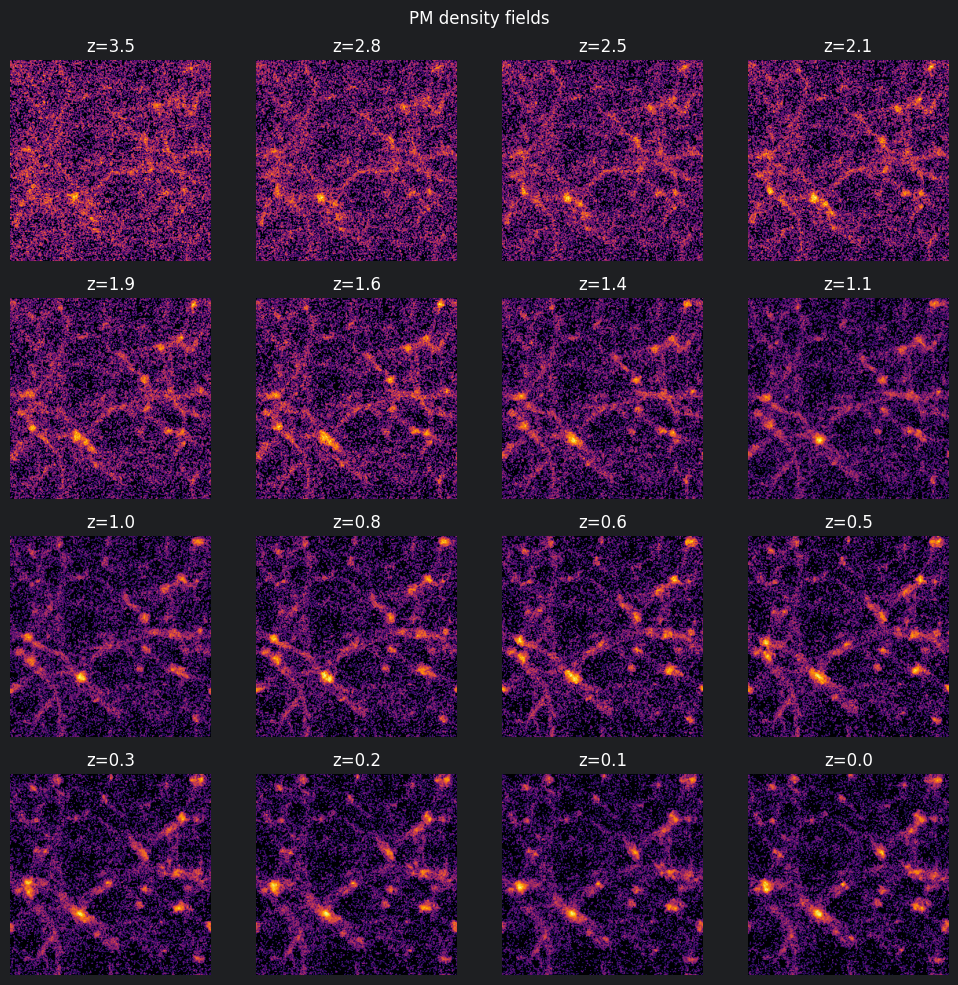

In [7]:
# Plotting parameters
display_one_z = False
new_nmesh = 256  # New density resolution
start, end = (-1, 0) if display_one_z else (0, 16)  # Range of redshifts to display
cutoff = 2e-1  # Avoiding zero-value denominator and rescale image
colormap = plt.get_cmap('inferno')

plt.figure(figsize=(5, 5) if display_one_z else (10, 10))
plt.suptitle("PM density field" + ("s" if not display_one_z else ""))
for i in range(start, end):
    if not display_one_z:
        plt.subplot(4, 4, i + 1)
    plt.imshow(np.log(cic_paint(jnp.zeros([new_nmesh] * 3), pm_pos[3::2][i] * new_nmesh / n_mesh).sum(axis=0) + cutoff),
               cmap=colormap)
    plt.axis('off')
    plt.title(f"z={z[3::2][i]:.1f}")

plt.tight_layout()

## Power Spectra

/home/rouzib/.local/lib/python3.10/site-packages/jax/_src/lax/lax.py:513: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


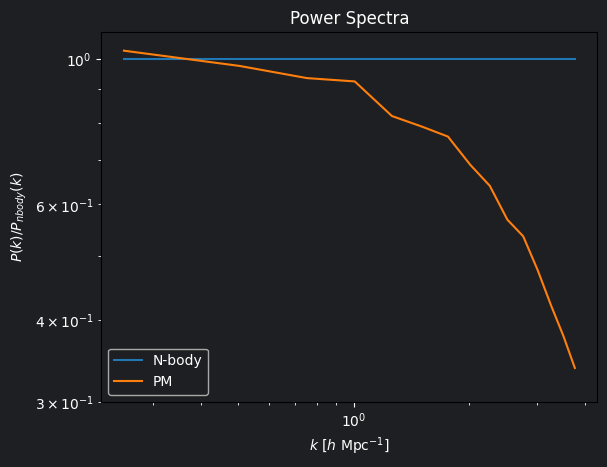

In [8]:
def compute_pk(positions: ArrayLike, n_mesh: int, box_size: ArrayLike) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """
    Compute the power spectrum.

    :param positions: The positions of the particles.
    :param n_mesh: The number of grid cells per dimension.
    :param box_size: The size of the simulation box.
    :return: The power spectrum and its corresponding wavenumbers.
    """
    return power_spectrum(compensate_cic(cic_paint(jnp.zeros([n_mesh, n_mesh, n_mesh]), positions)),
                          boxsize=np.array(box_size), kmin=np.pi / 25.0, dk=2 * np.pi / 25.0)


k, pk_nbody = compute_pk(positions=targetP[-1], n_mesh=n_mesh, box_size=box_size)
_, pk_pm = compute_pk(positions=pm_pos[-1], n_mesh=n_mesh, box_size=box_size)

plt.loglog(k, pk_nbody / pk_nbody, label="N-body")
plt.loglog(k, pk_pm / pk_nbody, label="PM")
plt.ylim(bottom=0.3, top=1.1)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k) / P_{nbody}(k)$")
plt.title(r"Power Spectra")
plt.legend()

## Cross Correlation

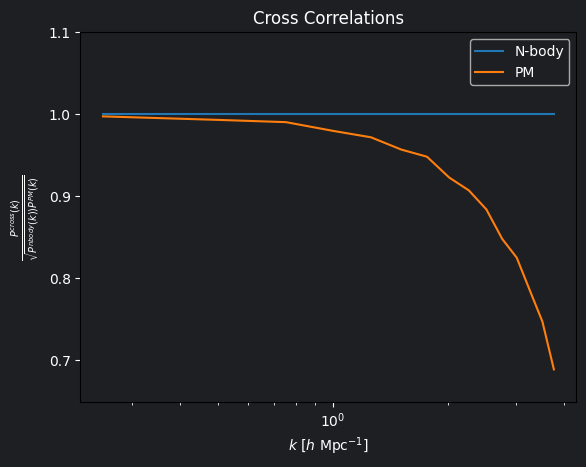

In [9]:
def compute_cc(target_positions: jnp.ndarray, positions: jnp.ndarray, n_mesh: int, box_size: jnp.ndarray) -> Tuple[
    jnp.ndarray, jnp.ndarray]:
    """
    Compute cross-correlation coefficients.

    :param target_positions: Array-like object containing the target positions.
    :param positions: Array-like object containing the positions.
    :param n_mesh: Integer representing the number of mesh points.
    :param box_size: Array-like object representing the size of the box.
    :return: Cross-correlation coefficients and its corresponding wavenumbers.
    """
    return cross_correlation_coefficients(
        compensate_cic(cic_paint(jnp.zeros([n_mesh, n_mesh, n_mesh]), target_positions)),
        compensate_cic(cic_paint(jnp.zeros([n_mesh, n_mesh, n_mesh]), positions)), boxsize=np.array(box_size),
        kmin=np.pi / 25., dk=2 * np.pi / 25.)


k, cc_pm = compute_cc(target_positions=targetP[-1], positions=pm_pos[-1], n_mesh=n_mesh, box_size=box_size)

plt.semilogx(k, pk_nbody / pk_nbody, label="N-body")
plt.semilogx(k, cc_pm / np.sqrt(pk_nbody * pk_pm), label='PM')
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$ \frac{P^{cross}(k)}{\sqrt{P^{nbody}(k))P^{PM}(k)}}$")
plt.ylim(bottom=0.65, top=1.1)
plt.title(r"Cross Correlations")
plt.legend()

# With the correction
## Defining the NN architecture

The model used for this problem should be invariant under translations and rotations. Here, in this case, the model takes as an input, the fourier transform of the mesh, the scale factors and the two cosmological parameters:
\begin{equation}f_{\theta}(a, |k|, \Omega_m, \sigma_8)\end{equation}
where:
 - $a$ is an array of scale factors,
 - $|k|$ is norm of the fourier transform of the mesh,
 - $\Omega_m$ and $\sigma_8$ are cosmological parameters.

Since the neural network is used here as a correction for an equation, symbolic regression could be used to make an explainable model.

Currently, the network used is a fully connected neural network whose outputs are the coefficients of a B-spline of order 3. The B-spline is composed of $16$ knots, and the fully connected network consists of $5$ hidden layers, each with a size of $32$.

In [10]:
def _deBoorVectorized(x, t, c, p):
    """
    :param x: Input vector of values.
    :param t: Knot vector defining the parameter space.
    :param c: Control points defining the curve.
    :param p: Degree of the B-spline curve.
    :return: The de Boor vectorized algorithm evaluates the B-spline curve at the given values `x`, using the knot vector `t`, control points `c`, and curve degree `p`.

    The algorithm calculates the B-spline curve values using the de Boor algorithm in a vectorized manner. It iteratively interpolates the control points based on the given values `x`, returning the curve values at the specified parameter values.
    """
    k = jnp.digitize(x, t) - 1

    d = [c[j + k - p] for j in range(0, p + 1)]
    for r in range(1, p + 1):
        for j in range(p, r - 1, -1):
            alpha = (x - t[j + k - p]) / (t[j + 1 + k - r] - t[j + k - p])
            d[j] = (1.0 - alpha) * d[j - 1] + alpha * d[j]
    return d[p]


class NeuralSplineFourierFilter(hk.Module):
    """A rotationally invariant filter parameterized by
    a b-spline with parameters specified by a small NN."""

    def __init__(self, n_knots: int = 8, latent_size: int = 16, name: str = None):
        """
        n_knots: number of control points for the spline
        """
        super().__init__(name=name)
        self.n_knots = n_knots
        self.latent_size = latent_size

    def __call__(self, x: jnp.ndarray, a: jnp.ndarray, cosmo: jnp.ndarray):
        """
        x: array, scale, normalized to fftfreq default
        a: scalar, scale factor
        """
        a = jnp.concatenate([jnp.array(cosmo), a])

        net = jnp.sin(hk.Linear(self.latent_size)(jnp.atleast_1d(a)))
        net = jnp.sin(hk.Linear(self.latent_size)(net))

        net = jnp.sin(hk.Linear(self.latent_size)(net))
        net = jnp.sin(hk.Linear(self.latent_size)(net))

        w = hk.Linear(self.latent_size)(net)
        k = hk.Linear(self.latent_size)(net)

        w = hk.Linear(self.n_knots + 1)(w)
        k = hk.Linear(self.n_knots - 1)(k)

        # make sure the knots sum to 1 and are in the interval 0,1
        k = jnp.concatenate([jnp.zeros((1,)), jnp.cumsum(jax.nn.softmax(k))])

        w = jnp.concatenate([jnp.zeros((1,)), w])

        # Augment with repeating points
        ak = jnp.concatenate([jnp.zeros((3,)), k, jnp.ones((3,))])

        return _deBoorVectorized(jnp.clip(x / jnp.sqrt(3), 0, 1 - 1e-4), ak, w, 3)

In [11]:
def initialize_model(n_mesh: int, n_knots: int = 16, latent_size: int = 32):
    """
    Initiliaze the model with a random initial state

    :param n_mesh: The size of the mesh to be used for the model.
    :param n_knots: The number of knots to be used in the model. Defaults to 16.
    :param latent_size: The size of the latent space for the model. Defaults to 32.
    :return: A tuple containing the initialized model and its parameters.

    This method initializes a model by using the specified parameters. It creates a Model object of a specific type specified by the modelName. The model is initialized using the n_knot
    *s and latent_size parameters. The model is then transformed using the hk.transform() function and stored in the 'model' variable.

    A PRNGSequence object is created using the hk.PRNGSequence() function with a seed value of 1. This is used to generate random numbers for the model initialization process.

    An array 'kvec' is generated using the fftk() function with the size of the mesh. This array is used to calculate the 'kk' parameter using mathematical operations.

    The model is then initialized using the init() method of the 'model' object. The parameters are generated using the next() function on the rng_seq object, 'kk', and arrays of ones.

    The initialized model and its parameters are returned as a tuple.
    """
    model = hk.without_apply_rng(
        hk.transform(
            lambda x, a, c: NeuralSplineFourierFilter(
                n_knots=n_knots, latent_size=latent_size
            )(x, a, c)
        ),
    )
    rng_seq = hk.PRNGSequence(1)

    kvec = fftk([n_mesh, n_mesh, n_mesh])
    kk = jnp.sqrt(sum((ki / jnp.pi) ** 2 for ki in kvec))
    params = model.init(
        next(rng_seq), kk, jnp.ones([1]), jnp.ones([2]) * 0.3
    )
    return model, params


nKnots = 32
latentSize = 64
model, params = initialize_model(n_mesh=n_mesh, n_knots=nKnots, latent_size=latentSize)

## Loading params from pretrained models
```
import pickle

modelPaths = ["Model/MyModel_nMesh64_LH100-149_Lr0.001_regularization/model499.pkl"]
params_list = []
for modelPath in modelPaths:
    with open(modelPath, 'rb') as file:
        params = pickle.load(file)
    params_list.append(params)
```

## Loss function

The loss function used here is:

\begin{equation}
    \mathcal{L} = \sum_i\sum_{j=0}^{33}\left( ||x_{ij}^{\rm nbody} -x_{ij}||_2^2 + \lambda||v_{ij}^{\rm nbody} -v_{ij}||_2^2\right) + \gamma\sum_i \beta_i^2 \, .
\end{equation}

Where: 
- $x_{ij}$ and $v_{ij}$ denote the position and velocity of particle $i$ at snapshot $j$, respectively. 
- $\beta_i$ are the weights in the fully-connected neural network. (L2 regularization)
- $\lambda$ and $\gamma$ are two hyperparameters used to control the influence of the various loss components and the regularization impact, respectively.

In this case $\lambda = 0.01$ and $\gamma = 0.01$.

Previous works (see this [paper](https://arxiv.org/pdf/2207.05509)) include the power spectra in the loss, but since it is the main performance metric, it would be good to avoid using it as a regularization. For an implementation, see the loss function in [src.Training](src/Training.py).

In [12]:
@partial(jax.jit, static_argnames=["model", "n_mesh", "velocity_loss", "regularization"])
def loss_fn(params, cosmology, target_pos, target_vel, scales, n_mesh, model, velocity_loss=False,
            regularization=False):
    """
    Compute the loss function for a given set of input parameters.

    :param params: A dictionary of neural network parameters.
    :param cosmology: A list of cosmological parameters.
    :param target_pos: The target position.
    :param target_vel: The target velocity.
    :param scales: The scales.
    :param n_mesh: The number of meshes.
    :param model: The neural network model.
    :param velocity_loss: Boolean indicating whether to include velocity loss. Default is False.
    :param regularization: Boolean indicating whether to include regularization loss. Default is False.
    :return: The computed loss value.
    """
    vel_contribution = 1e-2
    regularization_contribution = 1e-2

    # Exception handling: Checking for empty inputs for target position and velocity
    if len(target_pos) == 0 or len(target_vel) == 0:
        raise Exception(f"No data given: len(target_pos) = {len(target_pos)}, len(target_vel) = {len(target_vel)}")

    # Initializing Mean Squared Error (MSE)
    mse = 0

    # Calculate only the mean square error loss without considering the power spectrum loss
    for pos, vel, cosmo in zip(target_pos, target_vel, cosmology):
        # Setting initial conditions for the ODE solver
        pos_pm, vel_pm = odeint(make_neural_ode_fn(model, [n_mesh, n_mesh, n_mesh]),
                                [pos[0], vel[0]], scales, cosmo, params, rtol=1e-5, atol=1e-5)

        # Applying modulo operation to position prediction with number of mesh points to keep the positions on the
        # mesh
        pos_pm %= n_mesh

        # Calculating difference between predicted and true position
        dx = pos_pm - pos

        # Reflect the particle across the boundary if it goes beyond it.
        dx = dx - n_mesh * jnp.round(dx / n_mesh)

        # Calculate the squared differences
        sim_mse = jnp.sum(dx ** 2, axis=-1)

        # If velocity_loss flag is set, include the loss due to velocity prediction error
        if velocity_loss:
            dv = vel_pm - vel
            sim_mse += vel_contribution * jnp.sum(dv ** 2, axis=-1)

        # Add all the calculated losses to get the total mse
        mse += jnp.mean(sim_mse)

    # If regularization flag is set, add regularization loss to the final mse
    if regularization:
        regularizationTerm = 0
        for i in params.values():
            regularizationTerm += jnp.sum(jnp.array(list(i.values())[0]) ** 2)
        mse += regularization_contribution * regularizationTerm

    return mse / len(target_pos)  # Return mean mse by averaging over all targets

## Training the model

The training is done while backpropagating through the whole ode. Here, only one simulation is used during training, but since the model should accept different cosmological parameters (mainly $\Omega_m$ and $\sigma_8$) for different cosmologies, before deploying, the model should be trained using multiple simulations. See [src.Training](src/Training.py) for further details and a complete training code for the model used.

In [13]:
cpus = jax.devices("cpu")
gpus = jax.devices("gpu")

# Defined Constants
N_MESH = 32
BOX_SIZE = [25.0, 25.0, 25.0]
N_KNOTS = 16
LATENT_SIZE = 32
LEARNING_RATE = 0.001
N_STEPS = 250
VELOCITY_LOSS = True
REGULARIZATION = True
SNAPSHOT_LIST = range(34)

In [14]:
optimizer = optax.apply_if_finite(
    optax.chain(optax.clip_by_global_norm(10.0),
                optax.adam(LEARNING_RATE)),
    100)
opt_state = optimizer.init(params)

losses = []
val_losses = []

loss_fn_compiled = jax.value_and_grad(loss_fn)

In [15]:
@jax.jit
def training_step(params, opt_state, positions, velocities, cosmologies):
    """
    :param params: The current parameters of the model.
    :param opt_state: The optimizer state.
    :param positions: The positions of the particles.
    :param velocities: The velocities of the particles.
    :param cosmologies: The cosmologies.

    :return: A tuple containing the updated parameters, optimizer state, and the loss value.

    """
    loss, grads = loss_fn_compiled(params, cosmologies, positions, velocities, scale_factors, N_MESH, model,
                                   VELOCITY_LOSS, REGULARIZATION)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

if len(gpus) != 0:
    print(f"Using gpu: {gpus[0].device_kind}")
    scale_factors = jax.device_put(scale_factors, gpus[0])
    targetP = jax.device_put(targetP, gpus[0])
    targetV = jax.device_put(targetV, gpus[0])

pbar = tqdm(range(0, N_STEPS))
for step in pbar:
    tot_loss = 0

    # convert cosmology, targetP and targetV to lists since the loss function supports multiple simulations at the same time
    params, opt_state, loss = training_step(params, opt_state, [targetP], [targetV], [cosmology])
    tot_loss += loss

    pbar.set_postfix({"Step": step, "Loss": tot_loss})
    losses.append(tot_loss)

params_list = [params]

Using gpu: NVIDIA GeForce RTX 3090


100%|██████████| 250/250 [03:42<00:00,  1.13it/s, Step=249, Loss=0.41408756]


## Running the simulation with the model


To assess the efficacy of the corrections applied to particle mesh (PM) simulations, various performance metrics should be utilized:

1. **Power Spectrum Comparison**: The corrected PM simulation's power spectrum should ideally match that of the n-body simulation.
2. **Cross Correlation**: The cross-correlation between the PM and n-body simulations should approach a value close to 1, indicating high similarity.
3. **Density Field Analysis**: As a qualitative check, compare the density fields visually to ensure the correction maintains the integrity of the simulation.
4. **Velocity Distribution Check**: Evaluate whether the velocity distributions remain consistent, ensuring the correction does not introduce unrealistic velocities.

In [16]:
pm_pos_corr, pm_vel_corr = run_pm_model(pos=initialP, vels=initialV, redshifts=z, cosmo=cosmology, n_mesh=n_mesh,
                                        model=model, params=params_list)

/home/rouzib/.local/lib/python3.10/site-packages/jax/_src/lax/lax.py:513: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


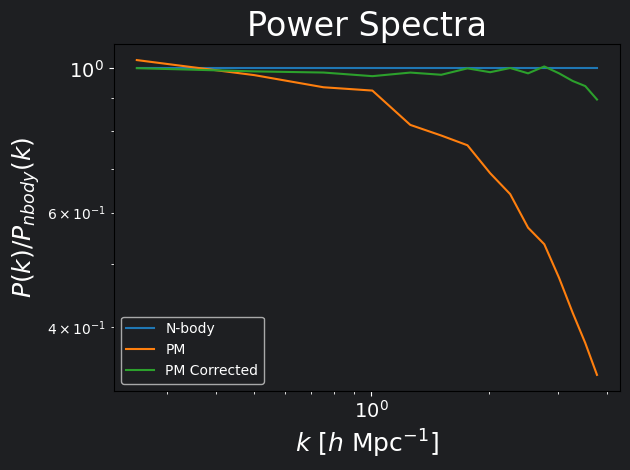

In [17]:
k, pk_pm_corr = compute_pk(positions=pm_pos_corr[-1], n_mesh=n_mesh, box_size=box_size)

plt.loglog(k, pk_nbody / pk_nbody, label="N-body")
plt.loglog(k, pk_pm / pk_nbody, label="PM")
plt.loglog(k, pk_pm_corr / pk_nbody, label="PM Corrected")
# plt.ylim(bottom=0.3, top=1.2)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", fontsize=18)
plt.ylabel(r"$P(k) / P_{nbody}(k)$", fontsize=18)
plt.title(r"Power Spectra", fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.tight_layout()

# plt.savefig("pk.png", transparent=True)

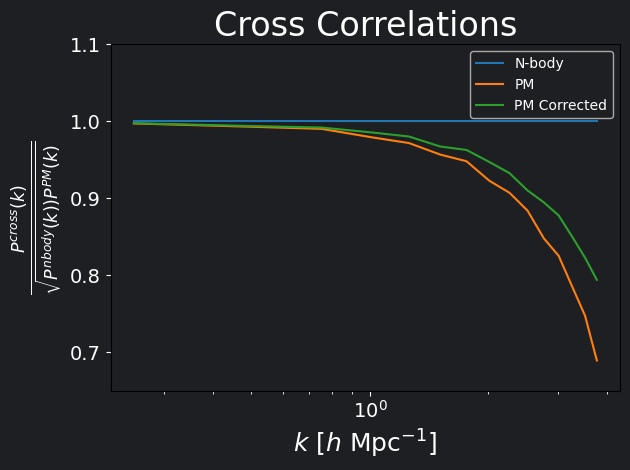

In [18]:
k, cc_pm_corr = compute_cc(target_positions=targetP[-1], positions=pm_pos_corr[-1], n_mesh=n_mesh, box_size=box_size)

plt.semilogx(k, pk_nbody / pk_nbody, label="N-body")
plt.semilogx(k, cc_pm / np.sqrt(pk_nbody * pk_pm), label='PM')
plt.semilogx(k, cc_pm_corr / np.sqrt(pk_nbody * pk_pm_corr), label='PM Corrected')
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", fontsize=18)
plt.ylabel(r"$ \frac{P^{cross}(k)}{\sqrt{P^{nbody}(k))P^{PM}(k)}}$", fontsize=18)
plt.ylim(bottom=0.65, top=1.1)
plt.title(r"Cross Correlations", fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.tight_layout()

# plt.savefig("cc.png", transparent=True)

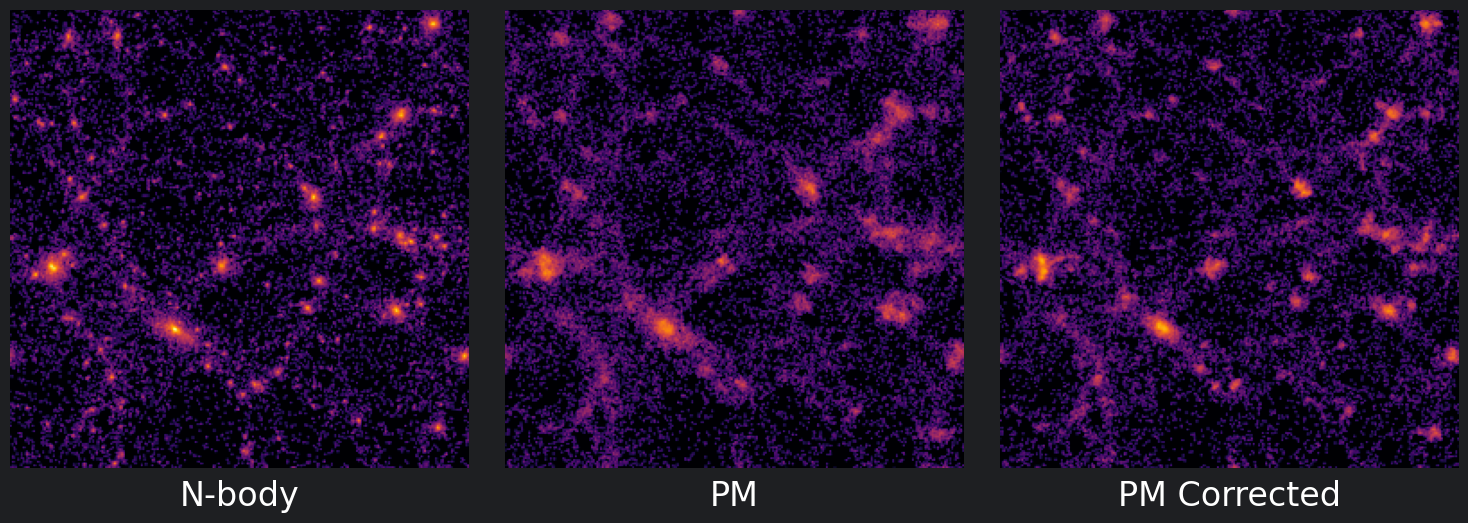

In [19]:
# Creating density fields
pm_density = cic_paint(jnp.zeros([new_nmesh, new_nmesh, new_nmesh]), pm_pos[-1] * new_nmesh / n_mesh)
pm_corr_density = cic_paint(jnp.zeros([new_nmesh, new_nmesh, new_nmesh]), pm_pos_corr[-1] * new_nmesh / n_mesh)
nbody_density = cic_paint(jnp.zeros([new_nmesh, new_nmesh, new_nmesh]), targetP[-1] * new_nmesh / n_mesh)

# Making the figure
vmin, vmax = np.log(nbody_density.sum(axis=0) + cutoff).min(), np.log(nbody_density.sum(axis=0) + cutoff).max()
plt.figure(figsize=(15, 5))
titleHeight = -0.1

# N-body simulation panel
plt.subplot(1, 3, 1)
plt.imshow(np.log(nbody_density.sum(axis=0) + cutoff), cmap=colormap, vmin=vmin, vmax=vmax)
plt.title("N-body", fontsize=24, y=titleHeight)
plt.axis('off')


# PM simulation panel
plt.subplot(1, 3, 2)
plt.imshow(np.log(pm_density.sum(axis=0) + cutoff), cmap=colormap, vmin=vmin, vmax=vmax)
plt.title("PM", fontsize=24, y=titleHeight)
plt.axis('off')

# PM corrected simulation panel
plt.subplot(1, 3, 3)
plt.imshow(np.log(pm_corr_density.sum(axis=0) + cutoff), cmap=colormap, vmin=vmin, vmax=vmax)
plt.title("PM Corrected", fontsize=24, y=titleHeight)
plt.axis('off')

plt.tight_layout()
# plt.savefig("DensityFields.png", transparent=True, bbox_inches='tight')

In our project, the corrected simulation achieves a power spectrum that aligns closely with the n-body simulation, even at higher $k$ values. However, the cross-correlation performance does not match that of the power spectrum. The density fields reveal that the corrected simulation is sharper than the standard particle mesh simulation, but it still significantly differs from the n-body simulation. Additionally, while the model is trained on velocities, it does not precisely replicate the n-body simulation's velocities and tends to introduce many particles with higher velocities.

## Velocity PDF

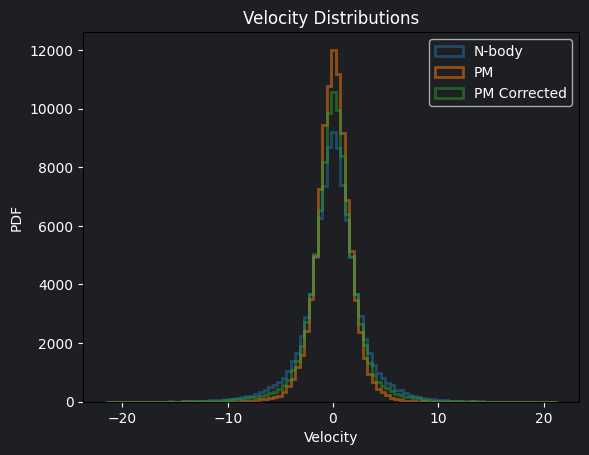

In [20]:
flattened_targetV = targetV[-1].flatten()
flattened_pm_vel = pm_vel[-1].flatten()
flattened_pm_vel_corr = pm_vel_corr[-1].flatten()

bins_number = 100

_, bins, _ = plt.hist(flattened_targetV, bins=bins_number, density=False, alpha=0.5, label="N-body", histtype='step',
                      linewidth=2)
plt.hist(flattened_pm_vel, bins=bins, density=False, alpha=0.5, label="PM", histtype='step', linewidth=2)
plt.hist(flattened_pm_vel_corr, bins=bins, density=False, alpha=0.5, label="PM Corrected", histtype='step', linewidth=2)
plt.xlabel('Velocity')
plt.ylabel('PDF')
plt.title('Velocity Distributions')
plt.legend()

There are several limitations in this project. While the n-body simulations are downsized to 32\^3 particles, they originally involve 256\^3 particles. This disparity means we aim to match particle positions that have experienced significantly more interactions than those in the particle mesh simulations. This discrepancy could lead to issues if the correction mechanism encounters scenarios with many particles, potentially causing an overcorrection of positions, especially in less populated scenarios.